In [116]:
import numpy as np 
import pandas as pd 
import cv2
import scipy
import math
import os, random
from skimage.metrics import structural_similarity
from PIL import Image
from numpy import r_
from scipy import fftpack
from matplotlib import pyplot as plt
from matplotlib.image import imread
%matplotlib inline

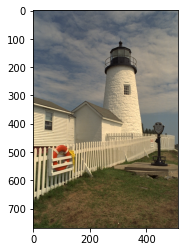

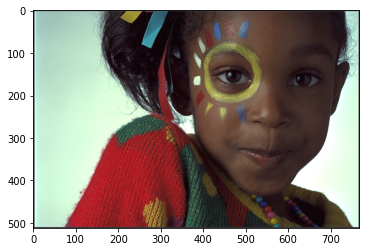

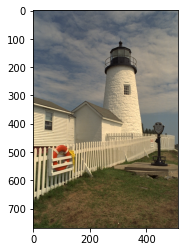

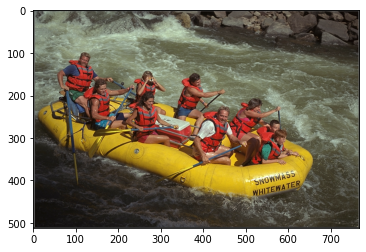

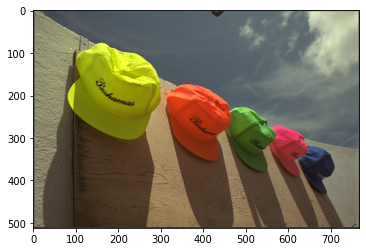

In [117]:
for i in range(5):
  imgPath = os.path.join('Kodak/', np.random.choice((os.listdir("Kodak"))))
  img = Image.open(imgPath)
  f = plt.figure()
  plt.imshow(img)

original image: (512, 768, 3)
grayscaled image: (512, 768)


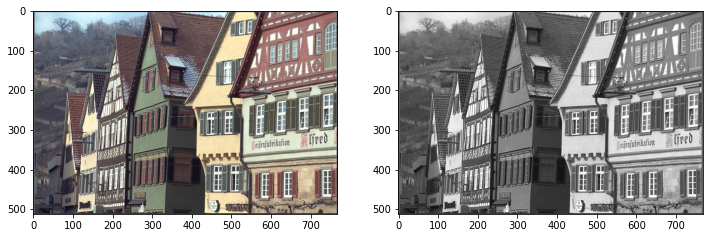

In [118]:
img_path = "Kodak/kodim08.png"
img = imread(img_path)
img_gray = np.mean(img, -1)

n_rows, n_cols = img_gray.shape

print(f'original image: {img.shape}')
print(f'grayscaled image: {img_gray.shape}')

fig = plt.figure(0, (12,6))
for idx, im in enumerate([img, img_gray]):
    ax = plt.subplot(1,2, idx+1)

    if len(im.shape)==2:
        ax.imshow(im, cmap='gray')
    else:
        ax.imshow(im)

#SVD Code

In [119]:
def svd(img, full_matrices=False):
    U, S, VT = np.linalg.svd(img, full_matrices=full_matrices)
    return (U, np.diag(S), VT)


# Evaluation Code


In [120]:
def psnr(original, compressed):
    mse = np.mean( (original - compressed) ** 2 )
    if mse == 0:
        return 100 
    PIXEL_MAX = 255.0
    return round((20 * math.log10(PIXEL_MAX / math.sqrt(mse))), 3)

def ssim(original, compressed):
    meanSSIM = structural_similarity(original, compressed, multichannel=True)
    return round(meanSSIM, 3) 

def perc_storage(rank, n_rows, n_cols):
    'calculate compresssion ratio in SVD'
    original_space = n_rows*n_cols
    compressed_space = n_rows*rank + rank + n_cols*rank
    return round(compressed_space / original_space * 100,2)
    
# def cr2(original, compressed):
#     nonZerosInOriginal = np.sum(original!=0)
#     nonZerosInCompressed = np.sum(compressed!=0)
#     return round(nonZerosInOriginal/nonZerosInCompressed, 3)
    
# def cr(original_img, compressed_img):
#     original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
#     compressed_img = cv2.cvtColor(compressed_img, cv2.COLOR_BGR2RGB)

#     original_img=cv2.imwrite("original.png", original_img)
#     print("Original File Size: "+str(os.path.getsize("original.png")))
    
#     compressed_img=cv2.imwrite("compressed.png", compressed_img)
#     print("Compressed File Size: "+str(os.path.getsize("compressed.png")))

#     return round(os.path.getsize("original.png")/os.path.getsize("compressed.png"), 3)
    
# def metrics( original_img, compressed_img ):
#     print("Achieved Peak Signal to Noise Ratio: " + str(psnr(original_img, compressed_img)))
#     print("Achieved SSIM : " + str(ssim(original_img, compressed_img)))
#     print("Achieved Compression Ratio: " + str(cr(original_img, compressed_img)))  
#     print("CR 2 = ", cr2(original_img, compressed_img))
#     return cr(original_img, compressed_img), psnr(original_img, compressed_img), ssim(original_img, compressed_img)

# Grayscale Compression

## Illustration using ranks 5, 25, 50, 100, 250

[]

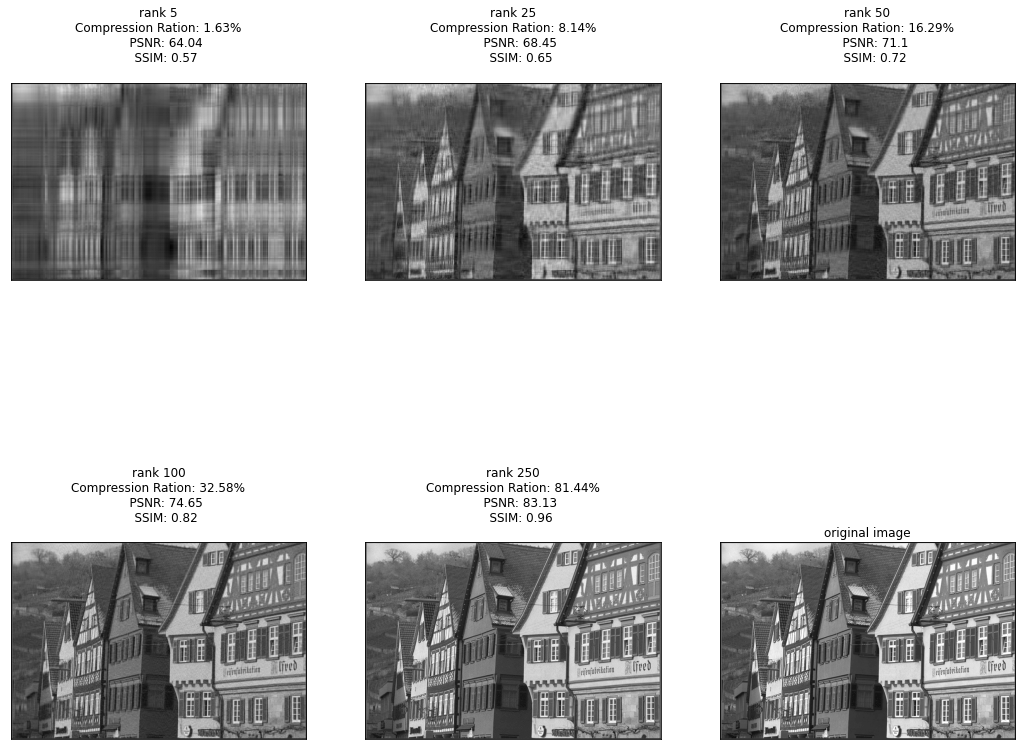

In [121]:
U, S, VT = svd(img_gray)

RANKS = [5, 25, 50, 100, 250]

fig = plt.figure(0, (18, 12))
fig.subplots_adjust(top=1.1)

for idx, r in enumerate(RANKS):
    X_r = U[:, :r] @ S[:r, :r] @ VT[:r, :]

    ax = plt.subplot(2,3, idx+1)
    ax.imshow(X_r, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    ax.set_title(f'''rank {r}\nCompression Ration: {perc_storage(r, n_rows, n_cols)}%
    PSNR: {round(psnr(img_gray, X_r), 2)}
    SSIM: {round(ssim(img_gray, X_r), 2)}
    ''')
    
ax = plt.subplot(2, 3, idx+2)
ax.imshow(img_gray, cmap='gray')
ax.set_title('original image')
ax.set_xticks([])
ax.set_yticks([])


## Compare performance using different ranks

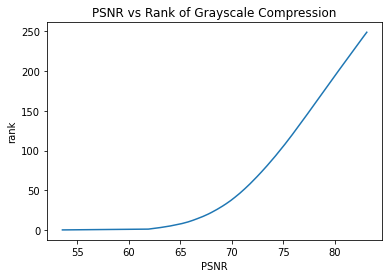

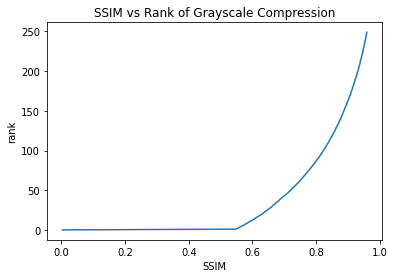

In [138]:
U, S, VT = svd(img_gray)

rank_list = [n for n in range(250)]
X_list = []
psnr_list = []
ssim_list = []
for r in rank_list:
  X_r = U[:, :r] @ S[:r, :r] @ VT[:r, :]
  p = psnr(img_gray, X_r)
  s = ssim(img_gray, X_r)

  X_list.append(X_r)
  psnr_list.append(p)
  ssim_list.append(s)



# plot PSNR vs rank
fig, ax = plt.subplots()
ax.plot(psnr_list, rank_list)
ax.set(xlabel='PSNR', ylabel='rank',
       title='PSNR vs Rank of Grayscale Compression')
plt.savefig('psnr-gray.png')
plt.show()


#plot SSIM vs rank
fig, ax = plt.subplots()
ax.plot(ssim_list, rank_list)
ax.set(xlabel='SSIM', ylabel='rank',
       title='SSIM vs Rank of Grayscale Compression')
plt.savefig('ssim-gray.png')
plt.show()



# Color Compression

## Illustration using ranks 5, 25, 50, 100, 250

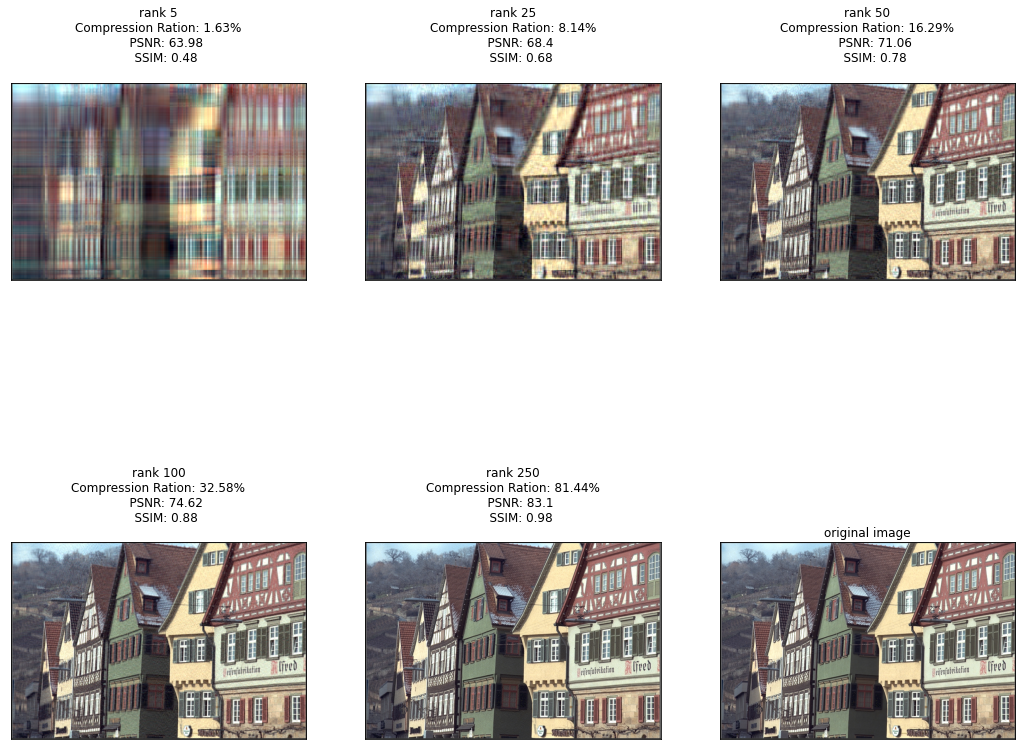

In [140]:
RANKS = [5, 25, 50, 100, 250]

red_channel, green_channel, blue_channel =  img[:, :, 0], img[:, :, 1], img[:, :, 2]

U_B, S_B, VT_B = svd(blue_channel)
U_G, S_G, VT_G = svd(green_channel)
U_R, S_R, VT_R = svd(red_channel)
    
fig = plt.figure(0, (18, 12))
fig.subplots_adjust(top=1.1)

for idx, r in enumerate(RANKS):
    XR_r = U_R[:, :r] @ S_R[:r, :r] @ VT_R[:r, :]
    XG_r = U_G[:, :r] @ S_G[:r, :r] @ VT_G[:r, :]
    XB_r = U_B[:, :r] @ S_B[:r, :r] @ VT_B[:r, :]

    X_r = np.dstack((XR_r, XG_r, XB_r))
    

    ax = plt.subplot(2,3, idx+1)
    ax.imshow(X_r)
    ax.set_xticks([])
    ax.set_yticks([])
        
    ax.set_title(f'''rank {r}\nCompression Ration: {perc_storage(r, n_rows, n_cols)}%
    PSNR: {round(psnr(img, X_r), 2)}
    SSIM: {round(ssim(img, X_r), 2)}
    ''')
    
ax = plt.subplot(2, 3, idx+2)
ax.imshow(img)
ax.set_title('original image')
ax.set_xticks([])
ax.set_yticks([])
plt.savefig('color-stack.png')

## Compare performance using different ranks

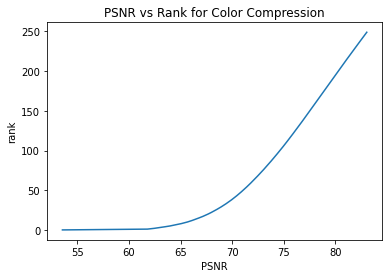

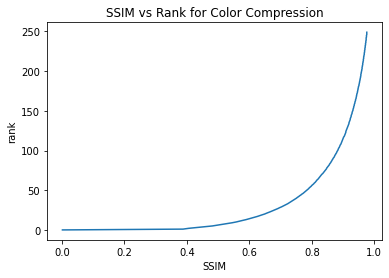

In [137]:
RANKS = [n for n in range(250)]
psnr_list = []
ssim_list = []

red_channel, green_channel, blue_channel =  img[:, :, 0], img[:, :, 1], img[:, :, 2]

U_B, S_B, VT_B = svd(blue_channel)
U_G, S_G, VT_G = svd(green_channel)
U_R, S_R, VT_R = svd(red_channel)

for r in (RANKS):
    XR_r = U_R[:, :r] @ S_R[:r, :r] @ VT_R[:r, :]
    XG_r = U_G[:, :r] @ S_G[:r, :r] @ VT_G[:r, :]
    XB_r = U_B[:, :r] @ S_B[:r, :r] @ VT_B[:r, :]

    X_r = np.dstack((XR_r, XG_r, XB_r))
    p = psnr(img, X_r)
    s = ssim(img, X_r)

    psnr_list.append(p)
    ssim_list.append(s)



# plot PSNR vs rank
fig, ax = plt.subplots()
ax.plot(psnr_list, rank_list)
ax.set(xlabel='PSNR', ylabel='rank',
       title='PSNR vs Rank for Color Compression')
plt.savefig('psnr-color.png')
plt.show()


#plot SSIM vs rank
fig, ax = plt.subplots()
ax.plot(ssim_list, rank_list)
ax.set(xlabel='SSIM', ylabel='rank',
       title='SSIM vs Rank for Color Compression')
plt.savefig('ssim-color.png')
plt.show()